In [71]:
%matplotlib inline   

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing  

import math              # package for mathematics (pi, arctan, sqrt, factorial ...)

import cmath 
from sympy import symbols, I, exp, diff, lambdify


# Computing the Intensity Profile of a Yagi Uda Antenna

In [233]:
"All lengths given in units of the wavelength lambda"
l_1 =  [0.5, 0.48, 0.46] #antenna lengths. 
l_2 =[0.003, 0.003, 0.003] #antenna radii
l_3 = [(0,0), (0.125,0), (0.25,0)] #antenna position

V = [0, 1, 0, 0, 0] #voltage in each antenna

def G_new(p, q, k, z, z_1, L_1, L_2, L_3):
   
    """

    Parameters
    ----------
    p, q: antenna indexes
    k : wavenumber
    z : 
    z_1 : z'
    L_1, L_2, L_3: list of antennas characteristic (ordered in the same order as the antennas in the linear array)
    Returns so called impedance kernel=Green function, used to compute the impedance coefficients
    -------
    """

    #print(L_2)
    if p == q:
        d = L_2[p]
    else:
        d = math.sqrt((L_3[p][0] - L_3[q][0])**2+ (L_3[p][1] - L_3[q][1])**2)
    #print(d)
    R = math.sqrt((z - z_1)**2 + d**2)
    if R < 1e-6:  # threshold for small distances
        return 0 
    #print(R)
    return (cmath.exp(-k * R*1j))/R


def Z_new(p, q, k=1):
    """
    Compute the coefficient of entry (p, q) of the impedance matrix (after integration by part). 
    In fact, no need to put k as argument.
    Note: The same formula can be retrieved with the near-field expression
    p, q: index of coeff Zpq in the impedance matrix

    """
    global l_1, l_2, l_3
    wavelength = 2*math.pi/k
    L_1 = [l*wavelength for l in l_1]
    L_2 = [l*wavelength for l in l_2]
    L_3 = [(x*wavelength, y*wavelength) for (x, y) in l_3]
    h_p = L_1[p]/2
    h_q = L_1[q]/2
    if p == q:
        N = 500 
    else:
        N = 300
    Z = 0
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    
    for n in range(-N//2, N//2+1):
        z_1 = (n*2*h_q)/N
        dz_1 = 2*h_q/N
        g1 = G_new(p, q, k, h_p, z_1, L_1, L_2, L_3)
        g2 = G_new(p, q, k, -h_p, z_1, L_1, L_2, L_3)
        g3 = G_new(p, q, k, 0, z_1, L_1, L_2, L_3)
        sinq = math.sin(k*(h_q- abs(z_1)))
        Z += sinq*(g1+g2-2*np.cos(k*h_p)*g3)*dz_1
    Z = Z*(complex(0, eta/(4*math.pi)))*1/(np.sin(k*h_p)*np.sin(k*h_q))          
    return Z   

In [234]:
def matrixZ_new(k):
    """
    Compute the impedance matrix Z for antenna arrays
    
    """
    n = len(l_1) #nb of antennas
    #matZ = np.matrix([[Z(p,q,k) for q in range(0,n)] for p in range(0,n)])
    matZ= np.zeros((n, n), dtype=complex)
    for p in range(0, n):
        for q in range(0, p+1):
            Z_pq =  Z_new(p,q,k)
            if p == q:
                matZ[p][q] = Z_pq
            else:
                matZ[p][q] = Z_pq
                matZ[q][p] = Z_pq
    return matZ

In [235]:
matrixZ_new(1)

array([[73.06760738+41.37285118j, 60.46223482 -0.96948387j,
        36.24973244-25.52686699j],
       [60.46223482 -0.96948387j, 64.92686417+11.79171722j,
        53.71666844 -2.71100182j],
       [36.24973244-25.52686699j, 53.71666844 -2.71100182j,
        57.64072287-16.93492283j]])

In [242]:
def input_current(V,Z):
    I = np.linalg.solve(Z, V)
    return I  

In [243]:
V = [0, 1]+[0]*(len(l_1)-2) #=[0, 1, 0, 0, 0] for 5 elements

In [273]:
def radiation_intensity(k, theta, phi, l1,l2,l3):
    """
    Radiation intensity for the SPECIFIC case of antenna arrays along x-axis, which needs to be refined for other types.
    k: wavenumber of the emitted wave
    theta, phi: spherical coordinates
    Issue solved at theta = 0, theta = pi
    """
    def identify_vector_arg(theta, phi):
        if np.ndim(theta) > 0:
            vector_arg = theta
        else:
            vector_arg = phi
        return vector_arg

    wavelength = 2*math.pi/k
    L_1 = [l*wavelength for l in l1]
    L_2 = [l*wavelength for l in l2]
    L_3 = [(x*wavelength, y*wavelength) for (x, y) in l3]
    
    eta = 376.7 #sqrt(mu_0/epsilon_0)
    I = input_current(V,matrixZ_new(k))
    
    M = identify_vector_arg(theta, phi)
    U = np.zeros_like(M, dtype=complex)  # to accumulate field
    for p in range(0, len(L_1)):
        h_p = L_1[p]/2
        term1 = np.exp(1j*k*np.sin(theta)*L_3[p][0]*np.cos(phi))
        if M is theta:
            mask = (theta != 0) & (theta != np.pi) #to deal with division by 0 at theta = 0 and theta = pi
            term2 = np.zeros_like(theta)
            term2[mask] = (np.cos(k*h_p*np.cos(theta[mask]))-np.cos(k*h_p))/(np.sin(k*h_p)*np.sin(theta[mask]))
        else:
            term2 =  (np.cos(k*h_p*np.cos(theta))-np.cos(k*h_p))/(np.sin(k*h_p)*np.sin(theta))
        U += I[p]*term1*term2
    return (eta/(8*np.pi**2))*abs(U)**2

def radiation_theta(k, phi, l1, l2, l3):
    theta = np.linspace(0, 2*np.pi, 500)  # θ from 0 to π (forward and backward hemisphere)
    U = radiation_intensity(k, theta, phi, l1, l2, l3)

    # Normalize intensity (optional, for clearer plot)
    U_norm = U / np.max(U)

    # Plot in polar coordinates
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection='polar')
    ax.plot(theta, U_norm)
    ax.set_title(f"Radiation Pattern at φ = {phi} (polar)", va='bottom')
    ax.grid(True)

    plt.show()

    return U, theta

def radiation_phi(k, theta, l1, l2, l3):
    phi = np.linspace(-np.pi, np.pi, 500)  # azimuthal angle range
    U = radiation_intensity(k, theta, phi, l1, l2, l3)

    # Normalize for clean polar plotting (optional)
    U_norm = U / np.max(U)

    # Plot in polar coordinates
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection='polar')
    ax.plot(phi, U_norm)
    ax.set_title(f"Radiation Pattern at θ = {theta} (polar)", va='bottom')
    ax.grid(True)

    plt.show()

    return U, phi
    

In [274]:
input_current(V,matrixZ_new(10))

array([-0.02895962+0.01784283j,  0.10631599-0.01913523j,
       -0.08055753-0.02488134j])

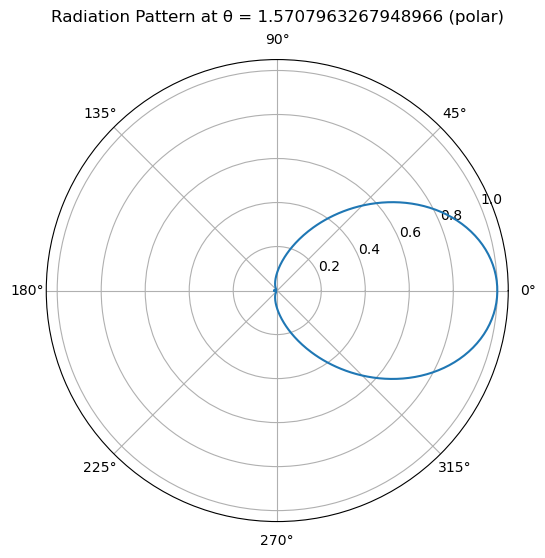

(array([0.00038098, 0.00038078, 0.00038019, 0.0003792 , 0.00037783,
        0.00037607, 0.00037393, 0.00037142, 0.00036854, 0.00036531,
        0.00036173, 0.00035782, 0.00035359, 0.00034905, 0.00034423,
        0.00033912, 0.00033376, 0.00032816, 0.00032233, 0.0003163 ,
        0.00031008, 0.0003037 , 0.00029719, 0.00029055, 0.00028381,
        0.000277  , 0.00027013, 0.00026324, 0.00025635, 0.00024947,
        0.00024264, 0.00023588, 0.00022921, 0.00022265, 0.00021624,
        0.00020999, 0.00020392, 0.00019807, 0.00019245, 0.00018709,
        0.00018201, 0.00017723, 0.00017276, 0.00016864, 0.00016489,
        0.00016151, 0.00015853, 0.00015597, 0.00015384, 0.00015216,
        0.00015095, 0.00015022, 0.00014998, 0.00015026, 0.00015105,
        0.00015237, 0.00015424, 0.00015666, 0.00015964, 0.0001632 ,
        0.00016733, 0.00017205, 0.00017737, 0.00018329, 0.00018981,
        0.00019695, 0.0002047 , 0.00021308, 0.00022208, 0.00023172,
        0.000242  , 0.00025292, 0.00026448, 0.00

In [275]:
radiation_phi(3*np.pi, np.pi/2, l_1,l_2,l_3)

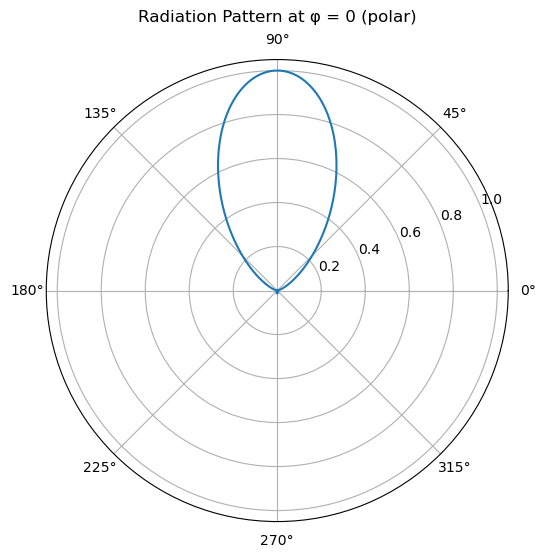

(array([0.00000000e+00, 2.65896384e-07, 1.10306456e-06, 2.57376491e-06,
        4.74445443e-06, 7.68596081e-06, 1.14736533e-05, 1.61876092e-05,
        2.19127749e-05, 2.87391205e-05, 3.67617862e-05, 4.60812206e-05,
        5.68033077e-05, 6.90394830e-05, 8.29068365e-05, 9.85282012e-05,
        1.16032227e-04, 1.35553434e-04, 1.57232255e-04, 1.81215048e-04,
        2.07654094e-04, 2.36707574e-04, 2.68539511e-04, 3.03319702e-04,
        3.41223609e-04, 3.82432229e-04, 4.27131934e-04, 4.75514279e-04,
        5.27775776e-04, 5.84117641e-04, 6.44745499e-04, 7.09869062e-04,
        7.79701764e-04, 8.54460365e-04, 9.34364514e-04, 1.01963628e-03,
        1.11049963e-03, 1.20717990e-03, 1.30990320e-03, 1.41889577e-03,
        1.53438334e-03, 1.65659045e-03, 1.78573967e-03, 1.92205087e-03,
        2.06574039e-03, 2.21702022e-03, 2.37609715e-03, 2.54317185e-03,
        2.71843796e-03, 2.90208115e-03, 3.09427815e-03, 3.29519579e-03,
        3.50498996e-03, 3.72380464e-03, 3.95177086e-03, 4.189005

In [276]:
radiation_theta(3*np.pi, 0, l_1,l_2,l_3)

# Investigating the Beam Width of a Yagi Uda Configuration

In [246]:
def beam_width_theta(k, phi, l1, l2, l3):
    # Compute radiation intensity and theta values once
    U =  radiation_theta(k,phi,l1,l2,l3)[0]
    theta = radiation_theta(k,phi,l1,l2,l3)[1]

    # Half-power threshold
    U_half = np.max(U) / 2
    deltaU = U - U_half

    indices = []
    i = 0
    while i < len(deltaU) - 1:
        # Falling edge: U > U_half to U < U_half
        while i < len(deltaU) - 1 and deltaU[i] > 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

        # Rising edge: U < U_half to U > U_half
        while i < len(deltaU) - 1 and deltaU[i] < 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

    # Final filter: remove any crossings where theta ≈ π (e.g. > π - 0.01)
    indices = [idx for idx in indices if theta[idx] < np.pi - 1e-2]


    if len(indices) < 2:
        print("Could not find enough valid half-power points.")
        return None
    


    # Beamwidth across all valid lobes
    return abs(theta[indices[-1]] - theta[indices[0]])

In [247]:
beam_width_theta(2*np.pi,0,l_1,l_2,l_3)

1.0828736200750388

In [248]:
def seperation_beamwidth_relation(k, l1, l2):
    # Generate separations from 0.1 to 1.0
    sep = np.linspace(0.1, 5.0, 500)

    # Create array of element positions for each separation
    configs = [[(i * dist, 0) for i in range(5)] for dist in sep]

    # Calculate beamwidths
    beam_widths = np.array([
        beam_width_phi0(k, l1, l2, config) for config in configs
    ])

    # Find the separation that gives the minimum beamwidth
    min_index = np.nanargmin(beam_widths)
    min_sep = sep[min_index]
    min_beamwidth = beam_widths[min_index]

    # Plot
    plt.plot(sep, beam_widths, label='Beamwidth vs Separation')
    plt.axvline(x=min_sep, color='r', linestyle='--', label=f'Min @ {min_sep:.3f}')
    plt.scatter([min_sep], [min_beamwidth], color='red')  # highlight min point
    plt.xlabel("Separation (λ)")
    plt.ylabel("Beamwidth (radians)")
    plt.title("Relation Between Element Separation and Beamwidth")
    plt.grid(True)
    plt.legend()
    plt.show()

    return min_sep

### Relating the Speration between Antennae to Beamwidth

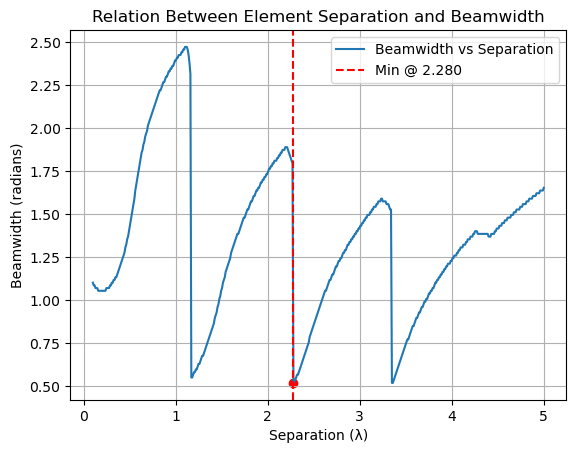

2.2799599198396794

In [249]:
seperation_beamwidth_relation(3*np.pi,l_1,l_2)

In [250]:
def beam_width_phi(k, theta, l1, l2, l3):
    # Compute radiation intensity and theta values once
    U =  radiation_phi(k,theta,l1,l2,l3)[0]
    phi = radiation_phi(k,theta,l1,l2,l3)[1]

    # Half-power threshold
    U_half = np.max(U) / 2
    deltaU = U - U_half

    indices = []
    i = 0
    while i < len(deltaU) - 1:
        # Falling edge: U > U_half to U < U_half
        while i < len(deltaU) - 1 and deltaU[i] > 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

        # Rising edge: U < U_half to U > U_half
        while i < len(deltaU) - 1 and deltaU[i] < 0:
            i += 1
        if i < len(deltaU) - 1:
            idx = i - 1
            if len(indices) == 0 or indices[-1] != idx:
                indices.append(idx)

    # Final filter: remove any crossings where theta ≈ π (e.g. > π - 0.01)
    indices = [idx for idx in indices if phi[idx] < np.pi - 1e-2]


    if len(indices) < 2:
        print("Could not find enough valid half-power points.")
        return None
    


    # Beamwidth across all valid lobes
    return abs(phi[indices[-1]] - phi[indices[0]])

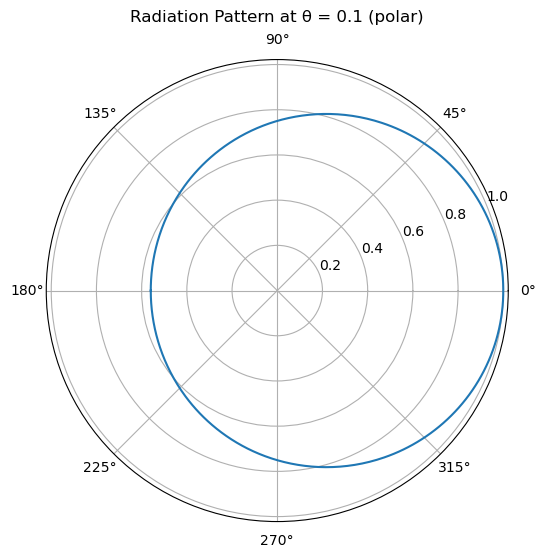

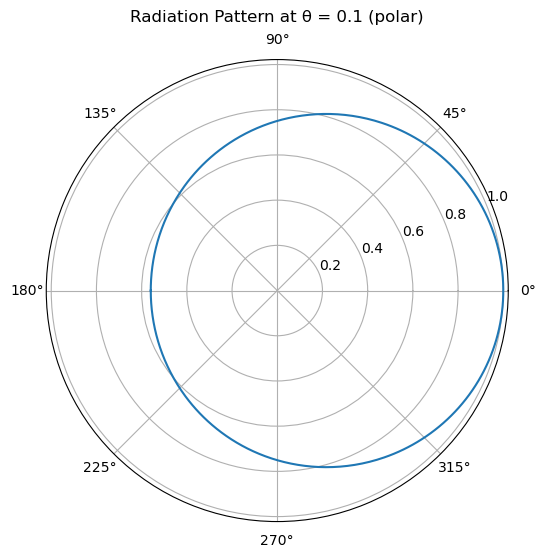

Could not find enough valid half-power points.


In [251]:
beam_width_phi(2*np.pi,0.1,l_1,l_2,l_3)

## Computation of the Directivity by Yagi

In [252]:
def compute_total_radiated_power(k, l1, l2, l3):
    # Define angular sampling grid
    theta = np.linspace(0, np.pi, 200)         # Elevation angle
    phi = np.linspace(0, 2 * np.pi, 200)       # Azimuth angle
    THETA, PHI = np.meshgrid(theta, phi, indexing='ij')  # Shape: (len(theta), len(phi))

    # Get radiation intensity U(θ, φ)
    U = radiation_intensity(k,THETA, PHI,l1, l2, l3)        # Must return 2D array matching shape of THETA

    # Apply the Jacobian term sin(θ) for solid angle integration
    integrand = U * np.sin(THETA)

    # Numerically integrate over φ (axis=1) then θ (axis=0)
    P_rad = np.trapz(np.trapz(integrand, phi, axis=1), theta, axis=0)

    return P_rad 

In [253]:
def directivity(k, theta, phi, l1, l2, l3):
    THETA, PHI = np.meshgrid(theta, phi, indexing='ij')  # shape (len(theta), len(phi))

    # Compute radiation intensity U(θ, φ) over the grid
    U = radiation_intensity(k, THETA, PHI, l1, l2, l3)  # must return shape (100, 100)

    # Integrate to get total power radiated
    integrand = U * np.sin(THETA)
    P_rad = np.trapz(np.trapz(integrand, phi, axis=1), theta, axis=0)

    # Compute directivity: D(θ, φ) = 4π * U(θ, φ) / P_rad
    D = 4 * np.pi * U / P_rad
    return D

In [254]:
from mpl_toolkits.mplot3d import Axes3D

def directivity_plot(k, l1, l2, l3):
    # Angular grid
    theta = np.linspace(0, np.pi, 100)
    phi = np.linspace(0, 2 * np.pi, 100)
    THETA, PHI = np.meshgrid(theta, phi, indexing='ij')  # shape: (100, 100)

    # Get 2D directivity pattern over the θ–φ grid
    D = directivity(k, theta, phi, l1, l2, l3)  # must return shape (100, 100)

    if D.shape != THETA.shape:
        raise ValueError(f"Directivity shape {D.shape} does not match angular grid {THETA.shape}")

    # Normalize directivity to [0, 1] for color mapping
    R = D / np.max(D)

    # Spherical to Cartesian conversion
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)

    # Use intensity (directivity) as color
    colors = plt.cm.viridis(R)

    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(
        X, Y, Z,
        facecolors=colors,
        rstride=1, cstride=1,
        linewidth=0, antialiased=False
    )

    ax.set_title("3D Directivity Pattern (Colored by Intensity)", pad=20)
    ax.set_box_aspect([1, 1, 1])
    ax.axis('off')  # Clean look
    plt.show()

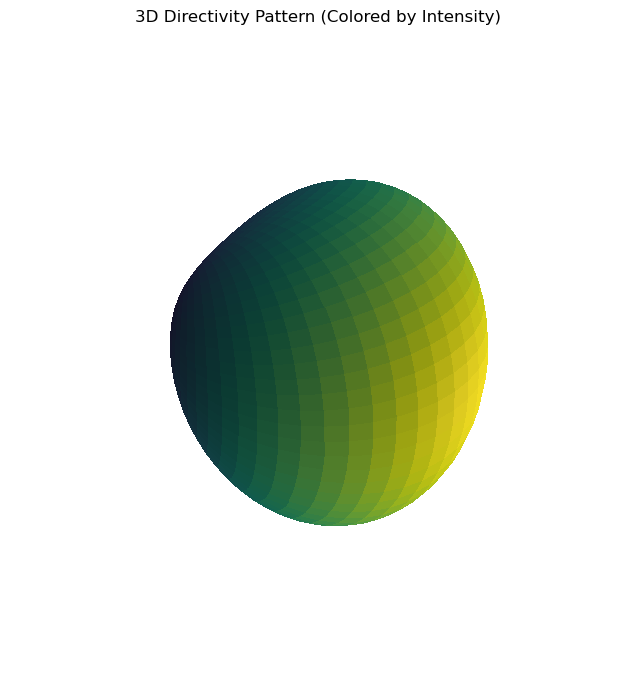

In [255]:
directivity_plot(1.047,l_1,l_2,l_3)